In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [46]:
df_combine = pd.read_csv('../Data/address_data_k.csv')
print(df_combine.shape)
print(df_combine.head())
f_txn = len(df_combine[df_combine['FLAG'] == 1])
print('current amount of fraud is now ', f_txn, ' which is ', (f_txn/len(df_combine))*100, ' % of the original dataset')

(9841, 51)
   Unnamed: 0  Index                                     Address  FLAG  \
0           0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8     0   
1           1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed     0   
2           2      3  0x0002bda54cb772d040f779e88eb453cac0daa244     0   
3           3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e     0   
4           4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89     0   

   Avg min between sent tnx  Avg min between received tnx  \
0                    844.26                       1093.71   
1                  12709.07                       2958.44   
2                 246194.54                       2434.02   
3                  10219.60                      15785.09   
4                     36.61                      10707.77   

   Time Diff between first and last (Mins)  Sent tnx  Received Tnx  \
0                                704785.63       721            89   
1                               12182

In [47]:
df_combine = df_combine.dropna()
print(df_combine.shape)

(8981, 51)


In [48]:
df_combine.nunique()

Unnamed: 0                                              8981
Index                                                   4722
Address                                                 8956
FLAG                                                       2
Avg min between sent tnx                                4809
Avg min between received tnx                            5796
Time Diff between first and last (Mins)                 7256
Sent tnx                                                 634
Received Tnx                                             720
Number of Created Contracts                               20
Unique Received From Addresses                           248
Unique Sent To Addresses                                 253
min value received                                      4422
max value received                                      6092
avg val received                                        6383
min val sent                                            4418
max val sent            

In [49]:
# dropping columns that have nunique values < 5 <- not useful features
constant_columns = ['Unnamed: 0', 'Index', ' ERC20 uniq sent addr.1', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
df_combine.drop(constant_columns,axis=1,inplace=True)
print(df_combine.shape)

(8981, 43)


In [50]:
# double check
df_combine.nunique()
# Interesting note : there are some addresses with more than 1 row

Address                                                 8956
FLAG                                                       2
Avg min between sent tnx                                4809
Avg min between received tnx                            5796
Time Diff between first and last (Mins)                 7256
Sent tnx                                                 634
Received Tnx                                             720
Number of Created Contracts                               20
Unique Received From Addresses                           248
Unique Sent To Addresses                                 253
min value received                                      4422
max value received                                      6092
avg val received                                        6383
min val sent                                            4418
max val sent                                            6304
avg val sent                                            5465
min value sent to contra

https://link.springer.com/chapter/10.1007/978-3-030-34223-4_2
Following this research article, I will try to apply the 3 classifiers mentioned
Namely, Random Forest, Support Vector Machines and XGBoost Classifiers

In [51]:
# First performing random forest
print('Random forest can only classify numerical columns, hence further processing needs to be done')
df_combine_forest = df_combine.select_dtypes(include='number')
print(df_combine_forest.shape)
print('3 columns have been dropped')

Random forest can only classify numerical columns, hence further processing needs to be done
(8981, 40)
3 columns have been dropped


In [52]:
x = df_combine_forest.drop('FLAG',axis=1)
print(x.shape)
y = df_combine_forest['FLAG'] # y_column needs to be 1d
print(y.shape)

(8981, 39)
(8981,)


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.7,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6286, 39), (2695, 39), (6286,), (2695,))

In [ ]:
# TOTAL_TREES = 100
# classifier_rf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=TOTAL_TREES)
# classifier_rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [54]:
# Hyperparameter tuning for random forest using gridsearchcv to fit the data

rf = RandomForestClassifier(random_state=42,n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV

In [55]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1,
                           verbose=1,
                           scoring="f1")

In [56]:
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='f1', verbose=1)

In [57]:
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

0.9167926811452456
RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=42)


In [63]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
rf = RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=50,n_jobs=-1,random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))

0.926261319534282
0.9397919025284381
0.8839506172839506
0.9788497217068646
0.9728260869565217


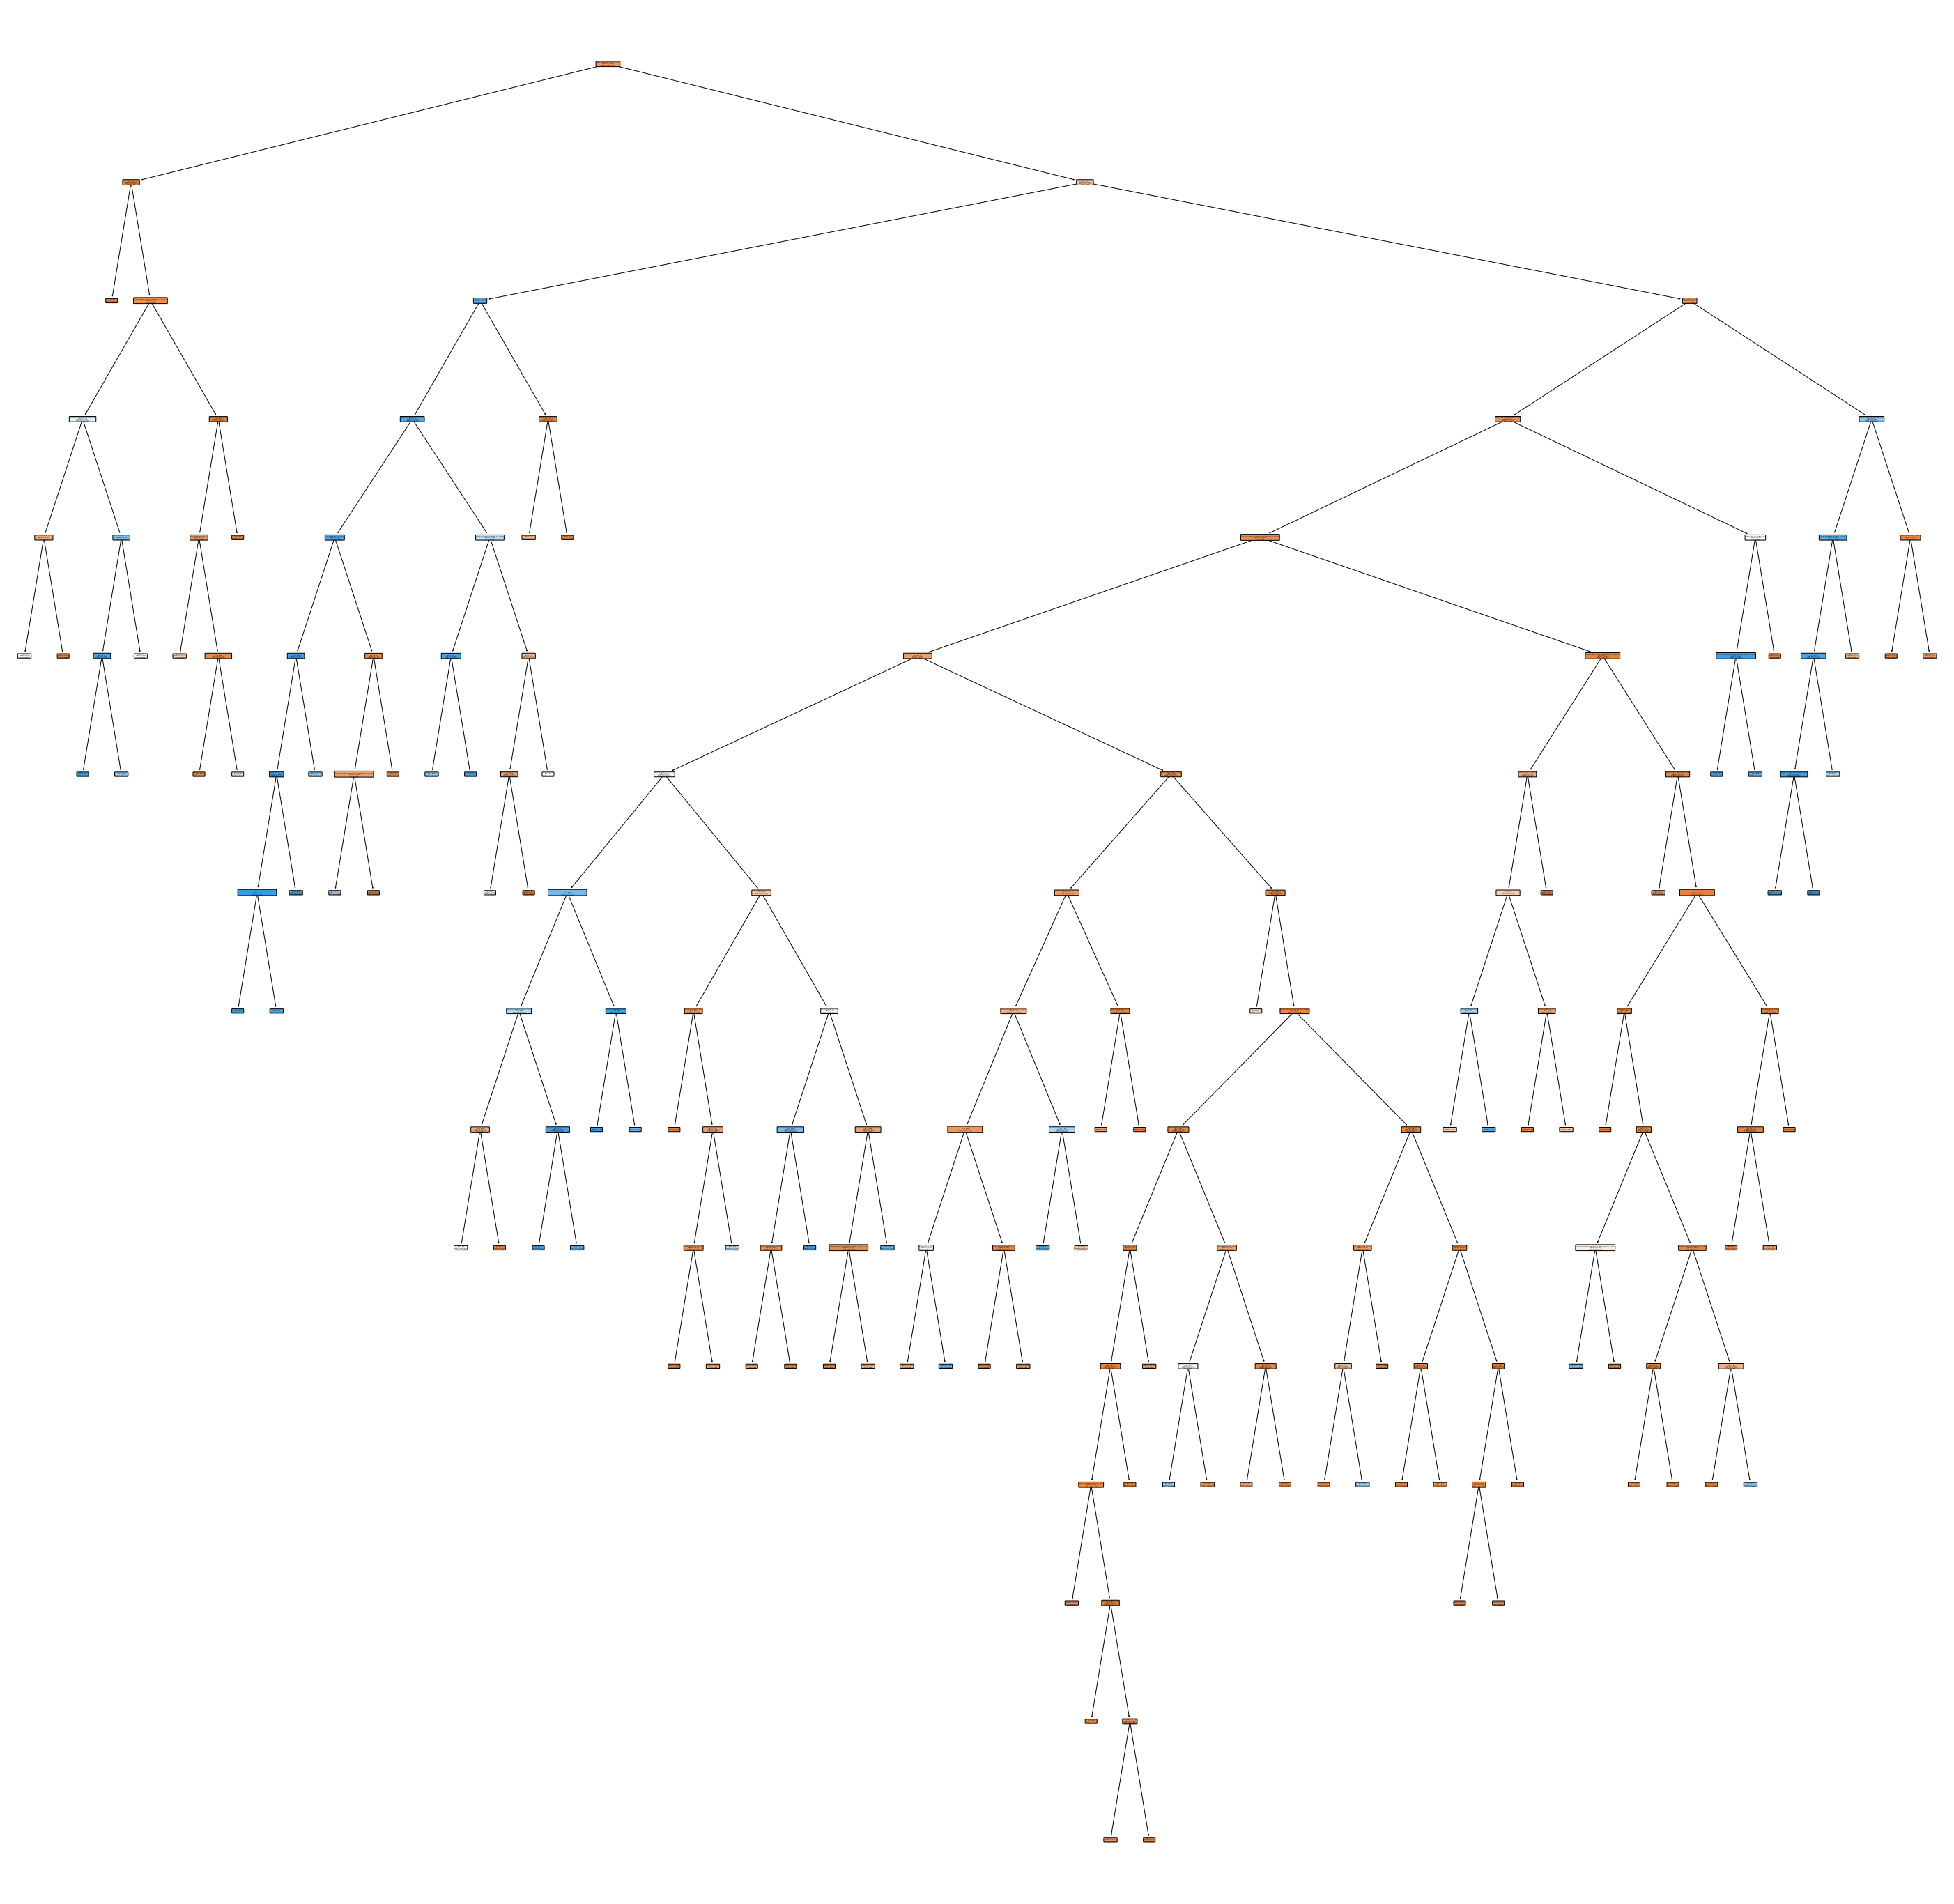

In [60]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50,50))
plot_tree(rf_best.estimators_[5], feature_names = x.columns,class_names=['Fraud', "No Fraud"],filled=True,proportion=True,rounded=True,precision=2)
plt.savefig("tree.eps")

In [61]:
# sorting the date by feature importance
rf_best.feature_importances_

array([0.00629456, 0.07137253, 0.12718422, 0.02334108, 0.02524476,
       0.00540783, 0.05465935, 0.00344624, 0.0059909 , 0.00835943,
       0.02375175, 0.0252212 , 0.00605875, 0.00813084, 0.        ,
       0.        , 0.        , 0.06140812, 0.01371261, 0.04254631,
       0.        , 0.01746837, 0.06026587, 0.06266366, 0.00662805,
       0.        , 0.00865967, 0.02297765, 0.03785505, 0.        ,
       0.        , 0.09995818, 0.06681462, 0.02923248, 0.00890112,
       0.0035872 , 0.00522437, 0.01290235, 0.04473089])

In [62]:
feature_imp_df = pd.DataFrame({
    "Features" : X_train.columns,
    "Importance" : rf_best.feature_importances_
})
feature_imp_df.sort_values(by="Importance",ascending=False)

,Features,Importance
2,Time Diff between first and last (Mins),0.127184
31,ERC20 min val rec,0.099958
1,Avg min between received tnx,0.071373
32,ERC20 max val rec,0.066815
23,ERC20 total Ether received,0.062664
17,total transactions (including tnx to create co...,0.061408
22,Total ERC20 tnxs,0.060266
6,Unique Received From Addresses,0.054659
38,ERC20 uniq rec token name,0.044731
19,total ether received,0.042546


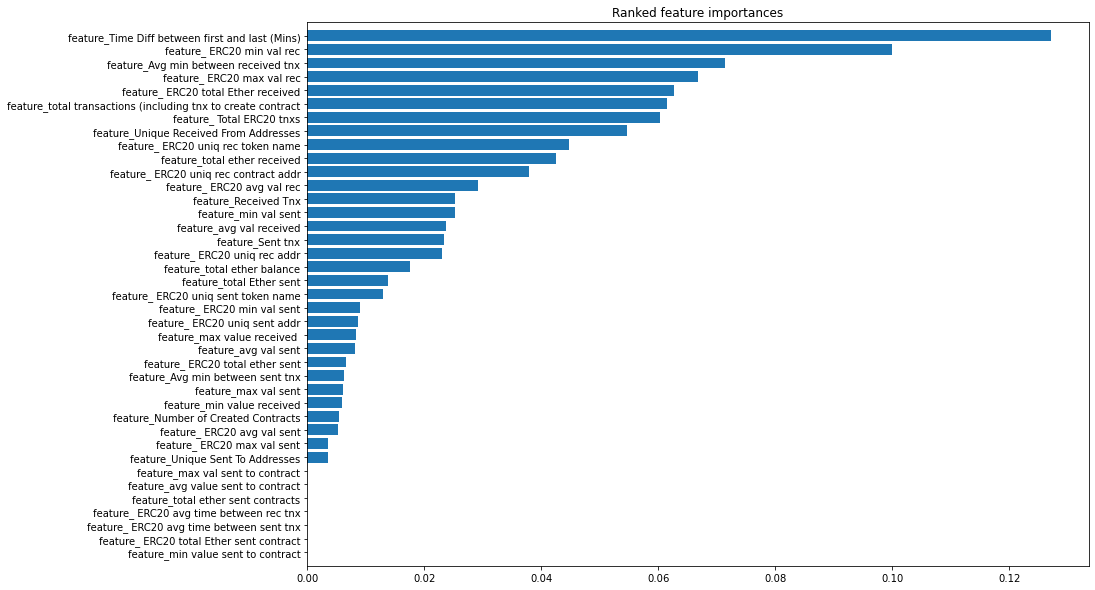

In [77]:
from matplotlib import pyplot as plt
feat_importances = rf_best.feature_importances_
indices = np.argsort(feat_importances)
# plot
columns = np.array(X_train.columns)
fig, ax = plt.subplots(figsize=(14, 10))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [74]:
np.array(X_train.columns)[38]

' ERC20 uniq rec token name'